# Lesson 8: Model Toolbox

## Intro to Quantified Cognition

<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/2022_Fall/notebooks/08_Model_Toolbox.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

## Lesson plan

- Review some best practices
- Example of paramter recovery
- Discuss Modeler's Toolbox
- Example of a Recognition Memory Model


## Best Practices

- Show model fit
- Assess parameter recovery
- Demonstrate selective influence
- Quantify uncertainty in parameter estimates
- Engage in model selection

(See great introduction by Heathcote et al., 2015)

## Showing model fit - Anscombe's Quartet

![](https://upload.wikimedia.org/wikipedia/commons/e/ec/Anscombe%27s_quartet_3.svg)


## Selective Influence

- One option is demonstration of ecological validity 
  - (e.g., success in a real-world application)
- Barring that, we can perform experimental manipulations to isolate individual processes in the model
  - e.g., Speed-accuracy trade-off or Bias
  - Turning complex effects into simpler accounts in terms of latent variables
  

## Parameter Recovery

- Use a model to generate data with known parameters
- Perform model fits to recover those parameters
- Poor parameter recovery suggests difficulty in model interpretation


## *ONLY* if on Google Colab

In [ ]:
# to install RunDEMC
!pip install --upgrade git+https://github.com/compmem/RunDEMC.git


In [ ]:
# to retrieve the data
!wget https://raw.githubusercontent.com/compmem/QuantCog/2022_fall/notebooks/CCR_quantcog.csv

In [ ]:
# to install more libraries
#!pip install plotnine
!pip install KDEpy
!pip install arviz

## Parameter Recovery Example

In [2]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats

import arviz as az

from RunDEMC import Model, Param, dists, calc_bpic, joint_plot
from RunDEMC.io import arviz_dict

from nu_wfpt import wfpt_like, wfpt_gen


In [71]:
# generate some data with WFPT
v = 1.4
a = 1.0
w = .45
t0 = .2
nsamp = 200
choices, rts = wfpt_gen(v_mean=v, a=a, w_mode=w, t0=t0, nsamp=nsamp)
all_dat = pd.DataFrame({'choice': choices, 'rt': rts})
print('Num. Non-Resp:', (all_dat.choice == 0).sum())
all_dat.head()

Num. Non-Resp: 0


,choice,rt
0,1.0,0.279
1,2.0,0.625
2,2.0,0.267
3,2.0,0.632
4,2.0,0.374


In [72]:
# only pick first n trials
n_trials = 100
dat = all_dat.iloc[:n_trials]

In [73]:
# normed histogram
def dhist(dat, nsims, alpha=.3, color='b'):
    p,b = np.histogram(dat,bins='auto',density=True)
    w = b[1]-b[0]
    p *= float(len(dat))/nsims
    return plt.bar(b[1:]-w,p,width=w,alpha=.3,color=color)


Text(0.5, 0, 'RT')

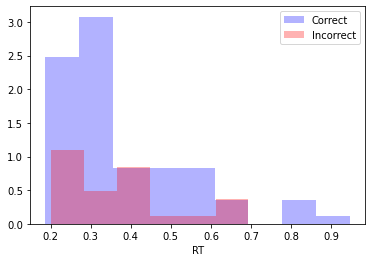

In [74]:
# plot our generated data
dhist(dat.loc[(dat['choice']==2), 'rt'], len(dat), color='b');
dhist(dat.loc[(dat['choice']==1), 'rt'], len(dat), color='r');
plt.legend(['Correct', 'Incorrect'])
plt.xlabel('RT')

In [75]:
# try to recover params
min_rt = dat.rt.min()

# set up the params
params = [Param(name='v', prior=dists.normal(0., 2.)),
          Param(name='w', prior=dists.normal(0, 1.4), transform=dists.invlogit),
          Param(name='a', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.normal(0, 1.4), 
                transform=lambda x: dists.invlogit(x)*min_rt)]
param_names = [p.name for p in params]

# define the likelihood function
def like_fun(pop, *args):
    log_likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # calc the likes
        likes = wfpt_like(dat['choice'].values, dat['rt'].values, 
                          a=p['a'], v_mean=p['v'], v_std=0.0, 
                          w_mode=p['w'], t0=p['t0'], w_std=0.0, 
                          nsamp=1000)
        with np.errstate(divide='ignore'):
            log_likes[i] += np.log(likes).sum()
        if log_likes[i] == -np.inf:
            continue

    return log_likes

       
# make the model
m = Model('wfpt', params=params,
          like_fun=like_fun,
          pop_parallel=True,
          #num_chains=120,
          #like_args=(param_names,),
          #purify_every=5,
          verbose=True)


In [76]:
# do some burnin
times = m.sample(100, burnin=True)
times = m.sample(600, burnin=False)

Initializing: 80(80) 4(4) 
Iterations (100):


Iterations (600):


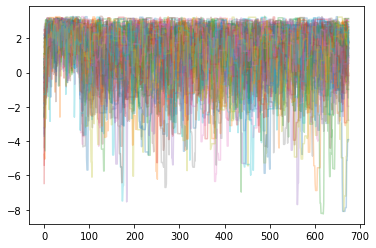

In [77]:
plt.plot(m.weights[25:], alpha=.3);

In [78]:
print("Best fitting params:")
burnin=200
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights[burnin:].ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] for i in range(m.particles.shape[-1])]
pp = {}
for p,val in zip(m.param_names,indiv):
    pp[p] = val
    print('"%s": %f,'%(p, val))

Best fitting params:
Weight: 3.2909625808510956
"v": 1.107717,
"w": 0.504214,
"a": 0.983082,
"t0": 0.201234,


In [79]:
# show model fit
xvals = np.linspace(0.0,2.0,1000)
def run_wfpt(v_mean=1.75, a=1.5, w_mode=.5, w_std=0.0,
             v_std=0.0, t0=0.0, nsamp=5000, err=.0001):

    ndat = len(dat)
    # plot the hist of the data, followed by the model PDF line
    dhist(np.array(dat.loc[(dat['choice']==2), 'rt']), ndat, color='b')
    likes = wfpt_like(np.ones(len(xvals))*2, xvals, v_mean, a, w_mode, w_std=w_std,
                      v_std=v_std, t0=0, nsamp=nsamp, err=err)
    plt.plot(xvals+t0, likes, color='b', lw=2.)
    
    dhist(np.array(dat.loc[(dat['choice']==1), 'rt']), ndat, color='r')
    likes = wfpt_like(np.ones(len(xvals))*1, xvals, v_mean, a, w_mode, w_std=w_std,
                      v_std=v_std, t0=0, nsamp=nsamp, err=err)
    plt.plot(xvals+t0, likes, color='r', lw=2.)
    #ylim(0,5.0)
    plt.xlim(0,2.0)

Text(0.5, 1.0, 'True Params')

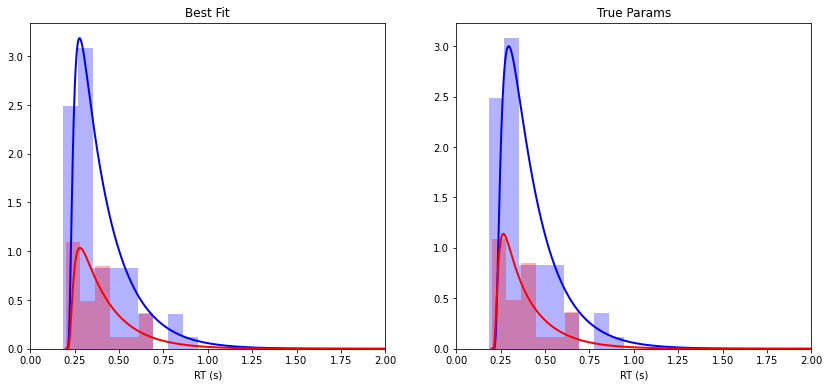

In [80]:
# set up new figure
plt.figure(figsize=(14,6))

# first plot best fits
plt.subplot(1,2,1)
run_wfpt(v_mean=pp['v'], a=pp['a'], w_mode=pp['w'], t0=pp['t0'])
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title("Best Fit")

# then true params
plt.subplot(1,2,2)
run_wfpt(v_mean=v, a=a, w_mode=w, t0=t0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title("True Params")



In [81]:
# save out model to an ArviZ Inference Dataset
daz = az.from_dict(**arviz_dict(m, burnin=200, step=3))
daz.posterior

<xarray.Dataset>
Dimensions:  (chain: 80, draw: 167)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 70 71 72 73 74 75 76 77 78 79
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 159 160 161 162 163 164 165 166
Data variables:
    v        (chain, draw) float64 1.469 1.469 1.409 ... 1.138 1.138 1.138
    w        (chain, draw) float64 0.483 0.483 0.4231 ... 0.5154 0.5154 0.5154
    a        (chain, draw) float64 1.04 1.04 1.033 ... 0.9564 0.9564 0.9564
    t0       (chain, draw) float64 0.1965 0.1965 0.1993 ... 0.2091 0.2091 0.2091
Attributes:
    created_at:     2022-10-20T16:39:30.648963
    arviz_version:  0.12.1

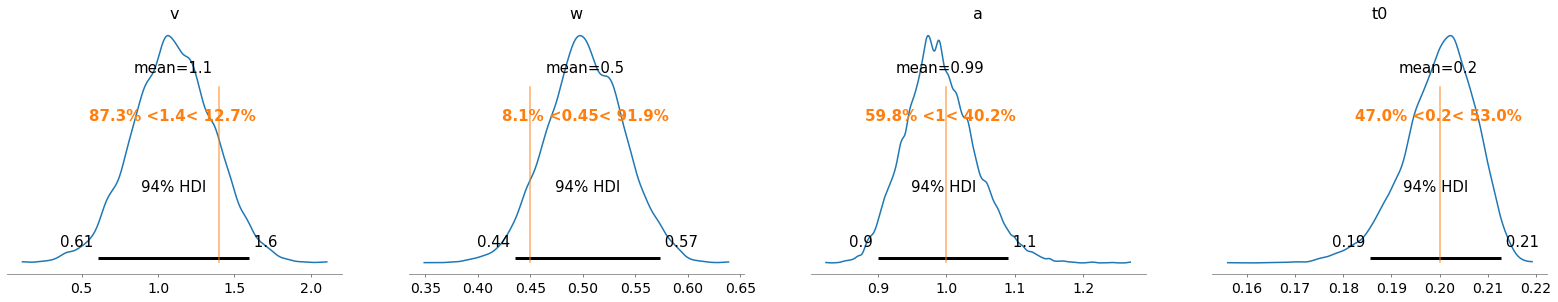

In [82]:
# see how the parameter recover worked out...
true_params = [v, w, a, t0]
az.plot_posterior(daz, ref_val=true_params);

## Model Toolkit

- What are the coding equivalents for common cognitive processes?
- Remember, it's all RAD...

## Items/Stimuli

- A cognitive model must *represent* the stimuli in your experiment. 
- This can be as simple as a vector


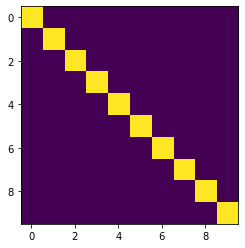

In [83]:
# orthogonal items in a list-learning experiment
nitems = 10
items = np.eye(nitems)

plt.imshow(items)

## Overlapping items

- Sometimes it's necessary for items to overlap (i.e., perceptually or semantically)
- Here you can simply add columns to your items

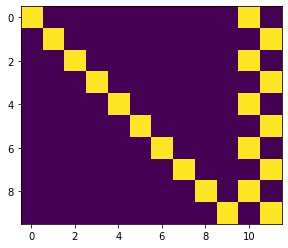

In [84]:
# overlapping items in a list-learning experiment
nitems = 10
ncolors = 2
nfeatures = nitems + ncolors
items = np.eye(nfeatures)
items = items[:nitems]

# add in color features
items[1::2, -1] = 1
items[::2, -2] = 1

plt.imshow(items)

## Working memory

- We can keep stimuli active, even when not just-presented
- Some options are:
  - buffers (e.g., SAM, Atkinson & Shiffrin)
  - exponential decay (e.g., TCM, Howard & Kahana)
  - time cells (e.g., SITH/TILT, Howard & Shankar)

Text(0, 0.5, 'Timestep')

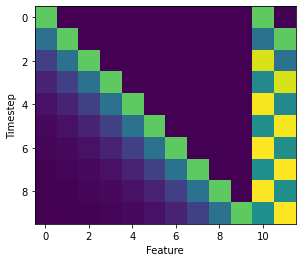

In [86]:
# present a list of items and store in working memory (context)
c = np.zeros(nfeatures)
c_save = []
rho = .5
for i in items:
    c = rho*c + (1-rho)*i
    c_save.append(c)
plt.imshow(c_save)
plt.xlabel('Feature')
plt.ylabel('Timestep')

Text(0, 0.5, 'Activation')

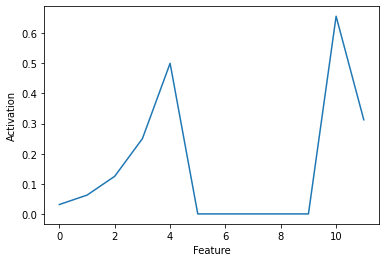

In [87]:
plt.plot(c_save[4])
plt.xlabel('Feature')
plt.ylabel('Activation')

## Associations

- In order to have a longer-term memory, we must form associations
- If items (and other information, such as working memory) are represented as a vector, you can store and update associations in a matrix
- There are *many* potential associative memory rules:
  - Hebbian (simple outer product)
  - Prediction-error (e.g., Rescorla--Wagner)

Text(0, 0.5, 'Feature')

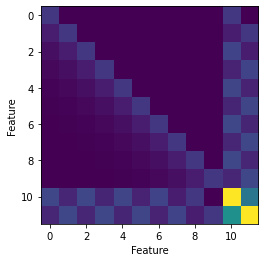

In [88]:
# form an outer product between an item and context
M = np.zeros((nfeatures, nfeatures))
for i in range(len(items)):
    M = M + np.outer(items[i], c_save[i])
plt.imshow(M)
plt.xlabel('Feature')
plt.ylabel('Feature')

## Querying Memory

- Once we have information stored in a matrix, you can pull it out with matrix multiplication (e.g., a dot product)

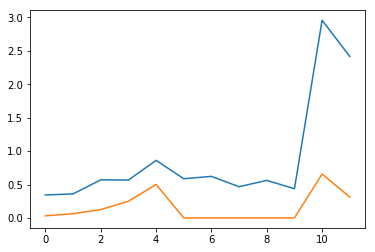

In [55]:
# retrieve an item from a context
s = np.dot(M, c_save[4])
plt.plot(s)
plt.plot(c_save[4])

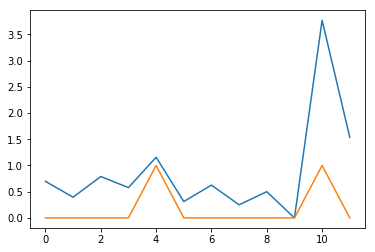

In [57]:
# probe from the other side to retrieve the context stored with an item
c_r = np.dot(items[4], M)
plt.plot(c_r)
plt.plot(items[4])

## Decisions

- If we have a strength value, we still need to generate a behavior
- Here we can employ many types of decision rules
- If we don't care about reaction-times, we can use a softmax rule ($\tau$ is a temperature parameter):

$$\frac{e^{\tau s_i}}{\sum_{j} e^{\tau s_j}}$$

$$\frac{s_i^\tau}{\sum_j s_j^\tau}$$

## Temporal Distinctiveness Example

In Siefke et al. (2019, *Memory & Cognition*) we wanted to test what it meant for an experience to be disctinctive:

https://link.springer.com/content/pdf/10.3758%2Fs13421-019-00925-5.pdf

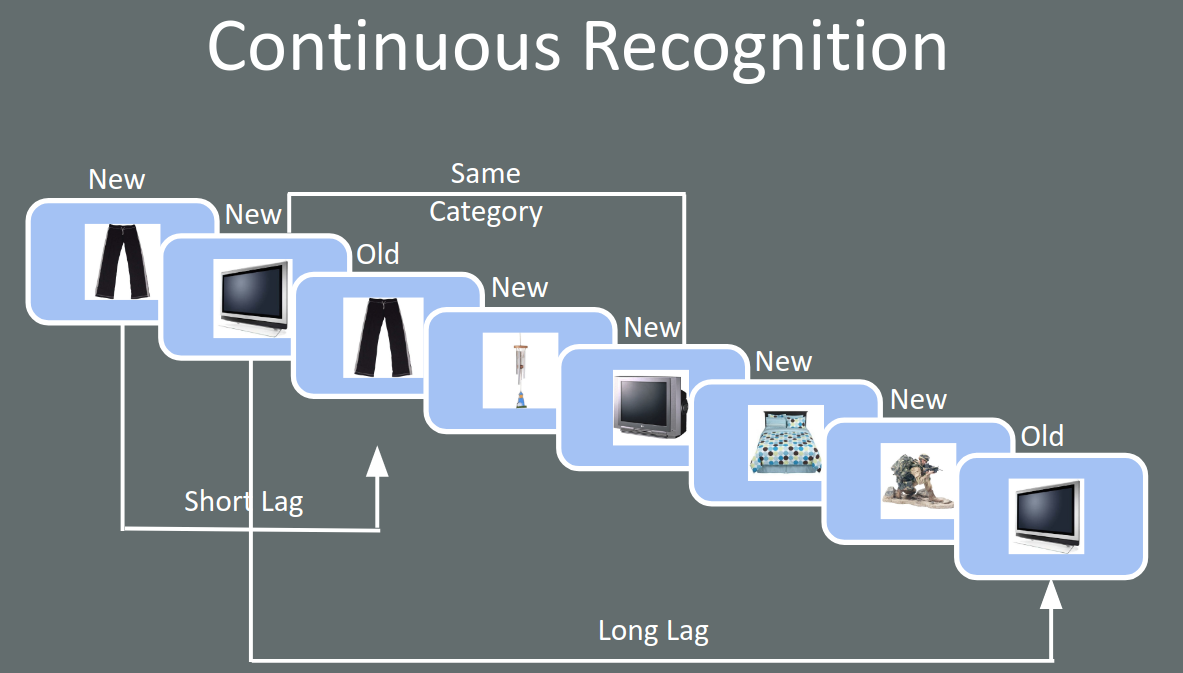

## Signal Detection Theory

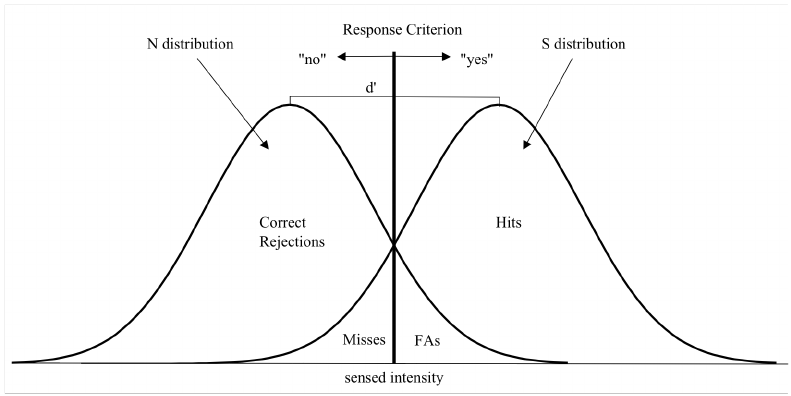


In [89]:
# import data
df_all = pd.read_csv('CCR_quantcog.csv', index_col='Unnamed: 0')
subs = np.unique(df_all['subj'])
df_all.head()



,appear_time_error,appear_time_time,base_time,block_num,cat,condition,correct,correct_resp,date,lag,...,rt,run_num,stim,trial_num,subj,datetime,press_time,passed,cat_obj_nums,cat_trial_nums
0,0,178101.3885,NaN,0,lantern,new,NaN,H,6/9/2017,1,...,NaN,0,/sdcard/smile_images/17-objects/lantern/lanter...,0,1,20170609_111649,NaN,1,1,1
1,0,178104.0019,178104.1878,0,lantern,old,0.0,G,6/9/2017,1,...,0.645822,0,/sdcard/smile_images/17-objects/lantern/lanter...,1,1,20170609_111649,NaN,1,1,2
2,0,178106.4705,178106.6570,0,saltpeppershake,new,1.0,H,6/9/2017,9,...,0.932769,0,/sdcard/smile_images/17-objects/saltpeppershak...,2,1,20170609_111649,NaN,1,1,1
3,0,178109.1085,178109.2959,0,balloon,new,1.0,H,6/9/2017,6,...,0.870521,0,/sdcard/smile_images/17-objects/balloon/ABALLO...,3,1,20170609_111649,NaN,1,1,1
4,0,178111.5771,178111.7734,0,juice,new,1.0,H,6/9/2017,9,...,0.690777,0,/sdcard/smile_images/17-objects/juice/XB0EO.jpg,4,1,20170609_111649,NaN,1,1,1


In [90]:
# Analysis code from Kevin Darby
def make_metric(df, min_rt = .35, max_rt = 2., acc_col = 'correct', rt_col = 'rt'):
    
    mask = (df[rt_col] > min_rt) & (df[rt_col] < max_rt)
    corr_trials = df[mask][acc_col]
#     print(corr_trials)
    rt_trials = df[mask][rt_col]
    
    num_trials = df[mask].shape[0]
    if num_trials > 0:
        avec=((np.sum(corr_trials)/float(num_trials))-.5)/.5
        rvec=(np.sum([(np.log(max_rt+1.)-np.log(r+1.))/((np.log(max_rt+1.)-np.log(min_rt+1.)))
                    for r in rt_trials])/num_trials)
        score = avec*rvec
    else:
        avec = np.nan
        rvec = np.nan
        score = np.nan
    return avec, rvec, score

def get_Az(hr,far,n_h, n_f):

    hr_trans = ((hr*n_h)+.5)/(n_h+1)
    far_trans = ((far*n_f)+.5)/(n_f+1)
    Z = stats.norm.ppf
    d = Z(hr_trans) - Z(far_trans)
    Az = stats.norm.cdf(d/np.sqrt(2))

    return d, Az



In [91]:
# More code from Kevin Darby
categ_nums = [1,2]

dats = {'subject': [], 'categ_num': [], 'lag': [], 'd': [], 'hr': [], 'far': []}

for sub in subs:
    df_sub = df_all[df_all['subj'] == sub]
    
    for num in categ_nums:
        df_num = df_sub[df_sub['cat_obj_nums'] == num]
        lags = df_num['lag'].unique()
        lags.sort()
        for lag in lags:
            this_df = df_num[df_num['lag'] == lag]

            new = this_df[this_df['condition'] == 'new']
            old = this_df[this_df['condition'] == 'old']

            # Number of old and new trials
            n_h = old.shape[0]
            n_f = new.shape[0]

            if n_h > 0 and n_f > 0:

                # Hit and false alarm rates
                hr = old[old['correct'] == 1].shape[0] / n_h
                far = new[new['correct'] == 0].shape[0] / n_f

                # Calculate d' and A_z
                d, Az = get_Az(hr, far, n_h, n_f)

            else:
                d = np.nan
                Az = np.nan
                hr = np.nan
                far = np.nan

            dats['subject'].append(sub)
            dats['categ_num'].append(num)
            dats['lag'].append(lag)
            dats['d'].append(d)
            dats['hr'].append(hr)
            dats['far'].append(far)
            
dats_df = pd.DataFrame(dats)

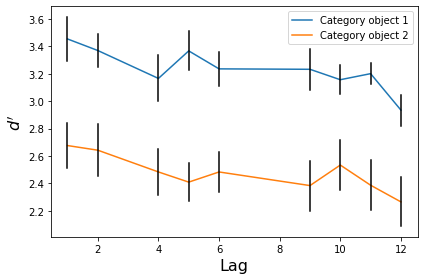

In [92]:
# plot d' as a function of lag and category
for num in [1, 2]:
    this_df = dats_df[dats_df['categ_num'] == num]
    lags = this_df['lag'].unique()
    lags.sort()

    means = [np.mean(this_df[this_df['lag'] == lag]['d']) for lag in lags]
    sems = [stats.sem(this_df[this_df['lag'] == lag]['d']) for lag in lags]
    
    ax = plt.gca()
    plt.plot(lags, means, label = 'Category object %s' %num);
    for i, sem in enumerate(sems):
        plt.plot([lags[i], lags[i]], [means[i] - sem, means[i] + sem], color = 'k')
    #chart_junk_be_gone(ax)

    plt.ylabel(r"$d'$", fontsize = 16)
    plt.xlabel('Lag', fontsize = 16)
    
plt.legend();

plt.tight_layout()

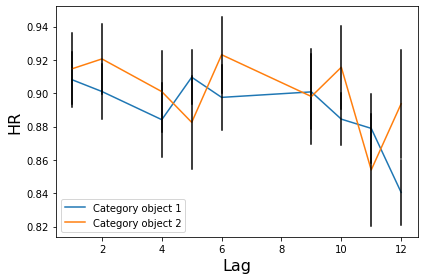

In [93]:
# plot HR as a function of lag and category
for num in [1, 2]:
    this_df = dats_df[dats_df['categ_num'] == num]
    lags = this_df['lag'].unique()
    lags.sort()

    means = [np.mean(this_df[this_df['lag'] == lag]['hr']) for lag in lags]
    sems = [stats.sem(this_df[this_df['lag'] == lag]['hr']) for lag in lags]
    
    ax = plt.gca()
    plt.plot(lags, means, label = 'Category object %s' %num);
    for i, sem in enumerate(sems):
        plt.plot([lags[i], lags[i]], [means[i] - sem, means[i] + sem], color = 'k')
    #chart_junk_be_gone(ax)

    plt.ylabel('HR', fontsize = 16)
    plt.xlabel('Lag', fontsize = 16)
    
plt.legend();

plt.tight_layout()


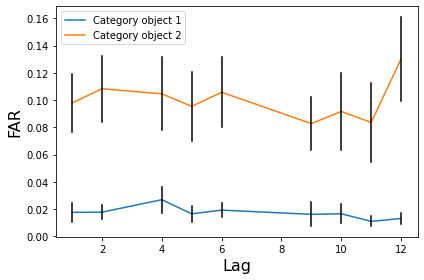

In [94]:
# plot FAR as a function of hit rate
for num in [1, 2]:
    this_df = dats_df[dats_df['categ_num'] == num]
    lags = this_df['lag'].unique()
    lags.sort()

    means = [np.mean(this_df[this_df['lag'] == lag]['far']) for lag in lags]
    sems = [stats.sem(this_df[this_df['lag'] == lag]['far']) for lag in lags]
    
    ax = plt.gca()
    plt.plot(lags, means, label = 'Category object %s' %num);
    for i, sem in enumerate(sems):
        plt.plot([lags[i], lags[i]], [means[i] - sem, means[i] + sem], color = 'k')
    #chart_junk_be_gone(ax)

    plt.ylabel('FAR', fontsize = 16)
    plt.xlabel('Lag', fontsize = 16)
    
plt.legend();

plt.tight_layout()


## Next Class: CCR Memory Model!!!